# Case Study AirBnB Price Prediction
This notebook walks through how to predict the real-value price of an AirBnB space in the AirBnB dataset


Example Business Case: We have data on a listing and want to predict the listing price

In [1]:
# Data Representation
import numpy as np
import pandas as pd

# Processing & Modeling
import sklearn
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import VotingRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler


from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# from sklearn import set_config
# set_config(display='diagram')   


import plotly.express as px

random_state = 42
pd.set_option('display.max_rows', 100)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# 1. kaggle_listings.csv
link_listings = 'https://drive.google.com/file/d/1tT0lNiDHwGQPLa3N0zSdhZcJZaa5aqF3/view?usp=sharing'
path_listings = 'https://drive.google.com/uc?export=download&id='+link_listings.split('/')[-2]

In [3]:
listings_df = pd.read_csv(path_listings)
listings_df = listings_df.rename(columns={'id':'listing_id'})
listings_df.head(1)

,listing_id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07


In [4]:
# 2. kaggle_calendar.csv
link_calendar = 'https://drive.google.com/file/d/1-xweLKOXLrdeMYqs3nnr4vQL4KiKyNVX/view?usp=sharing'
path_calendar = 'https://drive.google.com/uc?export=download&id='+link_calendar.split('/')[-2]

In [5]:
calendar_df = pd.read_csv(path_calendar)
calendar_df.head(5)

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


In [6]:
df = pd.merge(calendar_df, listings_df, on='listing_id')
df.shape

(1393570, 95)

## Clean & Preprocess Data

### Step 1: Clean Variables Manually

In [7]:
df.columns.values

array(['listing_id', 'date', 'available', 'price_x', 'listing_url',
       'scrape_id', 'last_scraped', 'name', 'summary', 'space',
       'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'thumbnail_url', 'medium_url', 'picture_url',
       'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since',
       'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic',
       'host_identity_verified', 'street', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'city',
       'state', 'zipcode', 'market', 'smart_location', 'country_code',
       'country', 'latitude', 'longitude', 'is_location_exact',
       'property_type', 'room_type', 'accommodates', 'bathrooms',

In [8]:
# remove observations where price_x == nan, because we need labeled data to predict price
df = df.dropna(subset=['price_x'])
df = df.rename(columns={'price_x':'price'})
df['price'] = df['price'].str.replace("[$, ]", "", regex=True).astype("float")
df.shape

(934542, 95)

In [9]:
df['price'].dtype

dtype('float64')

In [10]:
# drop the irrelevant columns
columns_to_drop = ['listing_id', 'available', 'host_id','host_location','host_acceptance_rate','host_neighbourhood',
                   'host_total_listings_count', 'weekly_price', 'monthly_price',
                   'security_deposit', 'cleaning_fee', 'calendar_updated',
                   'listing_url','last_scraped' ,'scrape_id', 'name', 'summary', 'space', 'description',
                   'experiences_offered', 'street', 'neighbourhood', 'neighbourhood_cleansed', 'zipcode',
                   'neighborhood_overview', 'notes', 'transit', 'thumbnail_url', 'medium_url', 'picture_url',
                   'xl_picture_url', 'host_url', 'host_name', 'host_about', 'host_thumbnail_url', 'host_picture_url',
                   'city', 'state', 'market', 'smart_location', 'country_code', 'country', 'latitude', 'longitude',
                   'is_location_exact', 'square_feet', 'has_availability', 'availability_30',
                   'availability_60', 'availability_90', 'availability_365', 'calendar_last_scraped',
                  'first_review', 'last_review', 'requires_license', 'license', 'jurisdiction_names', 'price_y',
                  'reviews_per_month', 'host_verifications', 'amenities']

In [11]:
df = df.drop(columns=columns_to_drop)

In [12]:
df['date'].dtype

dtype('O')

In [13]:
# extract year, month, day of day of week
df['date'] = pd.to_datetime(df['date'])
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year
df['day'] = df['date'].dt.dayofweek
df = df.drop(columns=['date'])

In [14]:
df['day'].value_counts()

0    135800
6    133615
1    133407
2    133375
3    132968
4    132803
5    132574
Name: day, dtype: int64

In [15]:
df['host_since']

0          2011-08-11
1          2011-08-11
9          2011-08-11
10         2011-08-11
14         2011-08-11
              ...    
1393207    2014-04-25
1393208    2014-04-25
1393211    2014-04-25
1393212    2014-04-25
1393213    2014-04-25
Name: host_since, Length: 934542, dtype: object

In [16]:
# convert host_since date into number and fill in missing values, drop the original column
# # extract year of host_since column
df['host_since'] = pd.to_datetime(df['host_since'])
df['host_since_year'] = df['host_since'].dt.year
df = df.drop(columns=['host_since'])

In [17]:
df['host_response_rate']

0           96%
1           96%
9           96%
10          96%
14          96%
           ... 
1393207    100%
1393208    100%
1393211    100%
1393212    100%
1393213    100%
Name: host_response_rate, Length: 934542, dtype: object

In [18]:
## TODO
# transform host response rate % into bucketed rate
df['host_response_rate'] = df['host_response_rate'].str.replace("%", "").astype("float")
df['host_response_rate'].fillna(df['host_response_rate'].mean(), inplace = True)
df['host_response_rate_buckets'] = pd.qcut(df['host_response_rate'], 5, labels=False, duplicates='drop')
df = df.drop(columns=['host_response_rate'])

In [19]:
df['host_response_rate_buckets'].value_counts()

1    747389
0    187153
Name: host_response_rate_buckets, dtype: int64

In [20]:
df['extra_people']

0          $5.00
1          $5.00
9          $5.00
10         $5.00
14         $5.00
           ...  
1393207    $0.00
1393208    $0.00
1393211    $0.00
1393212    $0.00
1393213    $0.00
Name: extra_people, Length: 934542, dtype: object

In [21]:
# create binary variable if fee is charged for extra people
df['extra_people_fee'] = df['extra_people'].apply(lambda row: False if row == '$0.00' else True)
df = df.drop(columns=['extra_people'])

In [22]:
df.shape

(934542, 36)

In [23]:
# % of NaN values
missing_series = pd.Series(1 - df.count() / len(df))
missing_series
# we need to do some imputation

price                               0.000000
host_response_time                  0.116115
host_is_superhost                   0.000098
host_listings_count                 0.000098
host_has_profile_pic                0.000098
host_identity_verified              0.000098
neighbourhood_group_cleansed        0.000000
property_type                       0.000331
room_type                           0.000000
accommodates                        0.000000
bathrooms                           0.005139
bedrooms                            0.002143
beds                                0.000391
bed_type                            0.000000
guests_included                     0.000000
minimum_nights                      0.000000
maximum_nights                      0.000000
number_of_reviews                   0.000000
review_scores_rating                0.154661
review_scores_accuracy              0.156806
review_scores_cleanliness           0.156150
review_scores_checkin               0.157102
review_sco

In [24]:
df.dtypes

price                               float64
host_response_time                   object
host_is_superhost                    object
host_listings_count                 float64
host_has_profile_pic                 object
host_identity_verified               object
neighbourhood_group_cleansed         object
property_type                        object
room_type                            object
accommodates                          int64
bathrooms                           float64
bedrooms                            float64
beds                                float64
bed_type                             object
guests_included                       int64
minimum_nights                        int64
maximum_nights                        int64
number_of_reviews                     int64
review_scores_rating                float64
review_scores_accuracy              float64
review_scores_cleanliness           float64
review_scores_checkin               float64
review_scores_communication     

In [25]:
df.shape

(934542, 36)

In [26]:
df_y = df.pop('price')
df_X = df.copy()

In [27]:
df_X.describe(include='object')

,host_response_time,host_is_superhost,host_has_profile_pic,host_identity_verified,neighbourhood_group_cleansed,property_type,room_type,bed_type,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification
count,826028,934450,934450,934450,934542,934233,934542,934542,934542,934542,934542,934542
unique,4,2,2,2,17,16,3,5,2,3,2,2
top,within an hour,f,t,t,Other neighborhoods,House,Entire home/apt,Real Bed,f,strict,f,f
freq,418108,746836,932831,738024,194661,436641,593215,894475,789226,359404,853861,837405


In [28]:
df_X.select_dtypes(exclude='object').columns # categorical

Index(['host_listings_count', 'accommodates', 'bathrooms', 'bedrooms', 'beds',
       'guests_included', 'minimum_nights', 'maximum_nights',
       'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'calculated_host_listings_count', 'month',
       'year', 'day', 'host_since_year', 'host_response_rate_buckets',
       'extra_people_fee'],
      dtype='object')

In [29]:
df_X.select_dtypes(include='object')

,host_response_time,host_is_superhost,host_has_profile_pic,host_identity_verified,neighbourhood_group_cleansed,property_type,room_type,bed_type,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification
0,within a few hours,f,t,t,Queen Anne,Apartment,Entire home/apt,Real Bed,f,moderate,f,f
1,within a few hours,f,t,t,Queen Anne,Apartment,Entire home/apt,Real Bed,f,moderate,f,f
9,within a few hours,f,t,t,Queen Anne,Apartment,Entire home/apt,Real Bed,f,moderate,f,f
10,within a few hours,f,t,t,Queen Anne,Apartment,Entire home/apt,Real Bed,f,moderate,f,f
14,within a few hours,f,t,t,Queen Anne,Apartment,Entire home/apt,Real Bed,f,moderate,f,f
...,...,...,...,...,...,...,...,...,...,...,...,...
1393207,within a day,f,t,t,Queen Anne,Apartment,Entire home/apt,Real Bed,f,flexible,f,f
1393208,within a day,f,t,t,Queen Anne,Apartment,Entire home/apt,Real Bed,f,flexible,f,f
1393211,within a day,f,t,t,Queen Anne,Apartment,Entire home/apt,Real Bed,f,flexible,f,f
1393212,within a day,f,t,t,Queen Anne,Apartment,Entire home/apt,Real Bed,f,flexible,f,f


### Step 2: Handle Categorical Variables
- Impute Missing Data
- Create Indicators (Dummies)

In [30]:
df_X['host_since_year'].unique()

array([2011., 2013., 2014., 2010., 2012., 2015., 2016., 2009.,   nan,
       2008.])

In [31]:
df_X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 934542 entries, 0 to 1393213
Data columns (total 35 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   host_response_time                826028 non-null  object 
 1   host_is_superhost                 934450 non-null  object 
 2   host_listings_count               934450 non-null  float64
 3   host_has_profile_pic              934450 non-null  object 
 4   host_identity_verified            934450 non-null  object 
 5   neighbourhood_group_cleansed      934542 non-null  object 
 6   property_type                     934233 non-null  object 
 7   room_type                         934542 non-null  object 
 8   accommodates                      934542 non-null  int64  
 9   bathrooms                         929739 non-null  float64
 10  bedrooms                          932539 non-null  float64
 11  beds                              934177 non-null  

In [32]:
df_X['accommodates'] = df_X['accommodates'].astype(object)
df_X['bathrooms'] = df_X['bathrooms'].astype(object)
df_X['bedrooms'] = df_X['bedrooms'].astype(object)
df_X['beds'] = df_X['beds'].astype(object)
df_X['guests_included'] = df_X['guests_included'].astype(object)
df_X['minimum_nights'] = df_X['minimum_nights'].astype(object)
df_X['maximum_nights'] = df_X['maximum_nights'].astype(object)

df_X['calculated_host_listings_count'] = df_X['calculated_host_listings_count'].astype(object)
df_X['month'] = df_X['month'].astype(object)
df_X['year'] = df_X['year'].astype(object)
df_X['day'] = df_X['day'].astype(object)

#df_X['host_since_year'] = df_X['host_since_year'].astype(object)
df_X['host_response_rate_buckets'] = df_X['host_response_rate_buckets'].astype(object)

In [33]:
# we will be using this variables for today's workshop
categorical_columns = df_X.select_dtypes(include=['object','bool']).columns # categorical
categorical_columns

Index(['host_response_time', 'host_is_superhost', 'host_has_profile_pic',
       'host_identity_verified', 'neighbourhood_group_cleansed',
       'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms',
       'beds', 'bed_type', 'guests_included', 'minimum_nights',
       'maximum_nights', 'instant_bookable', 'cancellation_policy',
       'require_guest_profile_picture', 'require_guest_phone_verification',
       'calculated_host_listings_count', 'month', 'year', 'day',
       'host_response_rate_buckets', 'extra_people_fee'],
      dtype='object')

In [34]:
# We are going to use scikit-learn pipeline class to impute missing values 
# and then create "dummy" indicator variables with the OneHotEncoder class

In [35]:
cat_pipeline = Pipeline([
      ("imputer", SimpleImputer(strategy='most_frequent')),
      ("cat", OneHotEncoder(handle_unknown='ignore')),
])
cat_pipeline

Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                ('cat', OneHotEncoder(handle_unknown='ignore'))])

In [36]:
df_X_categorical = cat_pipeline.fit_transform(df_X[categorical_columns])

In [37]:
df_X_categorical.shape

(934542, 253)

### Step 3: Handle Numerical Variables
- Impute Missing Data
- Scale Variables to Normal Distribution


In [38]:
df_X['review_scores_rating'].unique()

array([ 95.,  96.,  97.,  nan,  92.,  99.,  98., 100.,  80.,  85.,  84.,
        88.,  75.,  90.,  91.,  94.,  93.,  77.,  89.,  71.,  82.,  87.,
        73.,  83.,  86.,  76.,  78.,  66.,  74.,  60.,  64.,  70.,  68.,
        72.,  40.,  79.,  55.,  20.,  67.,  57.,  65.,  53.,  81.])

In [39]:
# For the sake of today's workshop, we will assume that the following are the "numerical" variables:
# we will be using this variables for today's workshop
non_categorical_columns = df_X.select_dtypes(exclude=['object','bool']).columns # non-categorical
non_categorical_columns

Index(['host_listings_count', 'number_of_reviews', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 'host_since_year'],
      dtype='object')

In [40]:
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="most_frequent")),  
        ('standard_scaler', StandardScaler()),              
    ])
num_pipeline

Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                ('standard_scaler', StandardScaler())])

In [41]:
df_X_non_categorical = num_pipeline.fit_transform(df_X[non_categorical_columns])

In [42]:
df_X_non_categorical.shape

(934542, 10)

### Step 4: Compose Processing Pipeline for All Variables 

In [43]:
full_pipeline = ColumnTransformer([
        ("categorical", cat_pipeline, categorical_columns),
        ("non-categorical", num_pipeline, non_categorical_columns),
    ])

X_train_set_prepared = full_pipeline.fit_transform(df_X)

In [44]:
# diplays HTML representation in a jupyter context
full_pipeline  

ColumnTransformer(transformers=[('categorical',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 Index(['host_response_time', 'host_is_superhost', 'host_has_profile_pic',
       'host_identity_verified', 'neighbourhood_group_cleansed',
       'property_type', 'room_type', 'accommodates', 'bathrooms', 'bed...
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('standard_scaler',
                                                  StandardScaler())]),
                                 Index(['host_listings_count', 'number_of_reviews', 'review_scores_rating',
  

## ML Price Prediction

### Step 1: Split Data into Train and Test

In [45]:
# Let's restart the session colab session to avoid potential crashes

In [46]:
df_X.shape

(934542, 35)

In [47]:
df_X.columns

Index(['host_response_time', 'host_is_superhost', 'host_listings_count',
       'host_has_profile_pic', 'host_identity_verified',
       'neighbourhood_group_cleansed', 'property_type', 'room_type',
       'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type',
       'guests_included', 'minimum_nights', 'maximum_nights',
       'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'instant_bookable', 'cancellation_policy',
       'require_guest_profile_picture', 'require_guest_phone_verification',
       'calculated_host_listings_count', 'month', 'year', 'day',
       'host_since_year', 'host_response_rate_buckets', 'extra_people_fee'],
      dtype='object')

In [48]:
df_y.shape

(934542,)

In [49]:
# We are going to split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.33, random_state=42)

In [50]:
f"The train set has {X_train.shape[0]} observations across {X_train.shape[1]} features used to predict prices ranging from {y_train.min()} to {y_train.max()}"

'The train set has 626143 observations across 35 features used to predict prices ranging from 10.0 to 1650.0'

In [51]:
f"The test set has {X_test.shape[0]} observations across the same {X_test.shape[1]} features used to test the fitted model in order to predict prices ranging from {y_test.min()} to {y_test.max()}"

'The test set has 308399 observations across the same 35 features used to test the fitted model in order to predict prices ranging from 20.0 to 1650.0'

In [52]:
X_train_fifty_thousand = X_train[:50000]
X_train_fifty_thousand.shape

(50000, 35)

In [53]:
y_train_fifty_thousand = y_train[:50000]
y_train_fifty_thousand.shape

(50000,)

In [54]:
X_train_ten_thousand = X_train[:10000]
X_train_ten_thousand.shape

(10000, 35)

In [55]:
y_train_ten_thousand = y_train[:10000]
y_train_ten_thousand.shape

(10000,)

### Step 2: Consider Performance Criteria

How will I know if the model performs well?

Three Common Criteria for Regression Based model  
1. Mean Squared Error (MSE)  
2. Root Mean Squared Error (RMSE)   
3. Mean Absolute Error (MAE)

#### Mean Squared Error (MSE)
- $MSE = \frac{1}{n} * \sum_{i=1}^{n}(y_i – \hat{y}_i)^2$
- A MSE of 0 is perfect, meaning all the predictions matched the true values exactly (and most likely your model has overfitted)
- Relative to a dataset

#### Root Mean Squared Error (RMSE)
- $RMSE = \sqrt{\frac{1}{n} * \sum_{i=1}^{n}(y_i – \hat{y}_i)^2}$
- The units of the RMSE are the same as the original units of the target value that is being predicted.
  + "For example, if your target variable has the units “dollars,” then the RMSE error score will also have the unit “dollars” and not “squared dollars” like the MSE." see [Regression Metrics for Machine Learning](https://machinelearningmastery.com/regression-metrics-for-machine-learning/)


#### Mean Squared Error (MAE)
- $MAE = \frac{\sum_{i=1}^{n}|y_{i} – x_{i}|}{n}$
- The units of the error score match the units of the target value that is being predicted.
- changes in MAE are linear unlike with RMSE


### Step 3: Prototype Models
1. Linear Regression
2. Random Forest
3. Gradient Boosting
4. Ensemble Voting

#### 1. Linear Regression

In [56]:
linear_regression = LinearRegression()
linear_regression_pipe = Pipeline([
            ("preprocessing", full_pipeline),
            ("lr", linear_regression)
       ])
linear_regression_pipe

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('cat',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['host_response_time', 'host_is_superhost', 'host_has_profile_pic',
       'host_identity_verified', 'neighbourhood_group_cleansed',
       'property_type', 'room_type...
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('standard_scaler',
                                                                   StandardScaler())]),
                    

In [57]:
# train linear regression and time training
%time linear_regression_pipe.fit(X_train_ten_thousand, y=y_train_ten_thousand)

CPU times: user 1.06 s, sys: 12.5 ms, total: 1.07 s
Wall time: 1.08 s


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('cat',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['host_response_time', 'host_is_superhost', 'host_has_profile_pic',
       'host_identity_verified', 'neighbourhood_group_cleansed',
       'property_type', 'room_type...
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('standard_scaler',
                                                                   StandardScaler())]),
                    

In [58]:
# get predictions from linear regression and time inferencing
%time y_pred = linear_regression_pipe.predict(X_test)

CPU times: user 5.06 s, sys: 97.7 ms, total: 5.16 s
Wall time: 5.12 s


In [59]:
print(f"MSE: {mean_squared_error(y_test, y_pred)}")
print(f"R^2: {r2_score(y_test, y_pred)}")

MSE: 3629.1650768861255
R^2: 0.6675376899448495


In [60]:
y_results = pd.DataFrame({'y_pred':y_pred, 'y_test':y_test, 'residuals': y_pred-y_test})

In [61]:
px.scatter(y_results,
            x='y_pred',  
            y='y_test',
            title="Predicted vs. Actuals",
            labels=dict(y_pred="Predicted Prices ($)", y_test="Actual Prices ($)")
           )

Output hidden; open in https://colab.research.google.com to view.

In [62]:
px.scatter(y_results,
           x='y_pred',  
           y='residuals',
           title="Residuals as a Function of Predicted Values",
           labels=dict(y_pred="Predicted Prices ($)", residuals="Residuals ($)")
           )

Output hidden; open in https://colab.research.google.com to view.

#### 2. Random Forest Regressor

In [63]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import tree

# Import tools needed for visualization
from graphviz import Source
from sklearn.tree import export_graphviz
import pydot

In [64]:
random_forest = RandomForestRegressor(n_estimators=100,
                                      criterion='squared_error', 
                                      random_state=random_state,
                                      n_jobs=-1)

In [65]:
random_forest_pipe = Pipeline([
            ("preprocessing", full_pipeline),
            ("rf", random_forest)
       ])
random_forest_pipe

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('cat',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['host_response_time', 'host_is_superhost', 'host_has_profile_pic',
       'host_identity_verified', 'neighbourhood_group_cleansed',
       'property_type', 'room_type...
                                                                  ('standard_scaler',
                                                                   StandardScaler())]),
                                                  Index(['host_listings_count', 'number_of_reviews', 'review_scores_rating',
    

In [66]:
# to save time, we are going to only train on 50,000 observations

In [67]:
X_train.shape

(626143, 35)

In [68]:
X_train_fifty_thousand = X_train[:50000]
X_train_fifty_thousand.shape

(50000, 35)

In [69]:
y_train_fifty_thousand = y_train[:50000]
y_train_fifty_thousand.shape

(50000,)

In [70]:
# train + train speed
%time random_forest_pipe.fit(X_train_fifty_thousand, y=y_train_fifty_thousand)

CPU times: user 16min 19s, sys: 1.11 s, total: 16min 20s
Wall time: 8min 52s


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('cat',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['host_response_time', 'host_is_superhost', 'host_has_profile_pic',
       'host_identity_verified', 'neighbourhood_group_cleansed',
       'property_type', 'room_type...
                                                                  ('standard_scaler',
                                                                   StandardScaler())]),
                                                  Index(['host_listings_count', 'number_of_reviews', 'review_scores_rating',
    

In [71]:
# inference + inference speed
%time y_pred = random_forest_pipe.predict(X_test)

CPU times: user 17.1 s, sys: 98.8 ms, total: 17.2 s
Wall time: 11.3 s


In [72]:
print(f"MSE: {mean_squared_error(y_test, y_pred)}")
print(f"R^2: {r2_score(y_test, y_pred)}")

MSE: 385.31341004359444
R^2: 0.964702022728535


In [73]:
random_forest_fast = RandomForestRegressor(n_estimators=68,
                                      criterion='squared_error', 
                                      random_state=random_state,
                                      n_jobs=-1)
random_forest_fast_pipe = Pipeline([
            ("preprocessing", full_pipeline),
            ("rf", random_forest_fast)
       ])
random_forest_fast_pipe

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('cat',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['host_response_time', 'host_is_superhost', 'host_has_profile_pic',
       'host_identity_verified', 'neighbourhood_group_cleansed',
       'property_type', 'room_type...
                                                                   StandardScaler())]),
                                                  Index(['host_listings_count', 'number_of_reviews', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checki

In [74]:
# to save time, we are going to only train on 10,000 observations

In [75]:
# train + train speed
%time random_forest_fast_pipe.fit(X_train_ten_thousand, y=y_train_ten_thousand)

CPU times: user 1min 35s, sys: 190 ms, total: 1min 35s
Wall time: 51.1 s


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('cat',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['host_response_time', 'host_is_superhost', 'host_has_profile_pic',
       'host_identity_verified', 'neighbourhood_group_cleansed',
       'property_type', 'room_type...
                                                                   StandardScaler())]),
                                                  Index(['host_listings_count', 'number_of_reviews', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checki

In [76]:
# inference + inference speed
%time y_pred_fast = random_forest_fast_pipe.predict(X_test)

CPU times: user 11.6 s, sys: 477 ms, total: 12 s
Wall time: 8.79 s


In [77]:
print(f"MSE: {mean_squared_error(y_test, y_pred_fast)}")
print(f"R^2: {r2_score(y_test, y_pred_fast)}")

MSE: 1500.0638941032707
R^2: 0.8625814210987056


#### 3. Gradient Boosting Regressor

In [78]:
from sklearn.ensemble import GradientBoostingRegressor

In [79]:
gradient_boosting = GradientBoostingRegressor(random_state=random_state)
gradient_boosting_pipe = Pipeline([
            ("preprocessing", full_pipeline),
            ("gb", gradient_boosting)
       ])
gradient_boosting_pipe

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('cat',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['host_response_time', 'host_is_superhost', 'host_has_profile_pic',
       'host_identity_verified', 'neighbourhood_group_cleansed',
       'property_type', 'room_type...
                                                                  ('standard_scaler',
                                                                   StandardScaler())]),
                                                  Index(['host_listings_count', 'number_of_reviews', 'review_scores_rating',
    

In [80]:
## Let's continue to train with just 10,000 observations

In [81]:
# train + train time
%time gradient_boosting_pipe.fit(X_train_ten_thousand, y=y_train_ten_thousand)

CPU times: user 2.82 s, sys: 128 ms, total: 2.95 s
Wall time: 2.95 s


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('cat',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['host_response_time', 'host_is_superhost', 'host_has_profile_pic',
       'host_identity_verified', 'neighbourhood_group_cleansed',
       'property_type', 'room_type...
                                                                  ('standard_scaler',
                                                                   StandardScaler())]),
                                                  Index(['host_listings_count', 'number_of_reviews', 'review_scores_rating',
    

In [82]:
# inference + inference time
%time y_pred = gradient_boosting_pipe.predict(X_test)

CPU times: user 5.67 s, sys: 112 ms, total: 5.78 s
Wall time: 5.77 s


In [83]:
print(f"MSE: {mean_squared_error(y_test, y_pred)}")
print(f"R^2: {r2_score(y_test, y_pred)}")

MSE: 3201.0639506683824
R^2: 0.706755385019134


#### 4. Ensemble Voting

In [84]:
voting_model = VotingRegressor([
    ('linear_regression', linear_regression_pipe), 
    ('random_forest', random_forest_fast_pipe), 
    ('gradient_boosting', gradient_boosting_pipe)]
)
voting_model

VotingRegressor(estimators=[('linear_regression',
                             Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(transformers=[('categorical',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('cat',
                                                                                                OneHotEncoder(handle_unknown='ignore'))]),
                                                                               Index(['host_response_time', 'host_is_superhost', 'host_has_profile_pic',
       'host_identity_verified', 'neighbo...
                                                                                               ('standard_sc

In [85]:
# train + train time
%time voting_model.fit(X_train_ten_thousand, y=y_train_ten_thousand)

CPU times: user 4.99 s, sys: 578 ms, total: 5.57 s
Wall time: 53.8 s


VotingRegressor(estimators=[('linear_regression',
                             Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(transformers=[('categorical',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('cat',
                                                                                                OneHotEncoder(handle_unknown='ignore'))]),
                                                                               Index(['host_response_time', 'host_is_superhost', 'host_has_profile_pic',
       'host_identity_verified', 'neighbo...
                                                                                               ('standard_sc

In [86]:
# Now let's look to see how each model performed
y_pred_1 = linear_regression_pipe.predict(X_test) # linear regression
y_pred_2 = random_forest_fast_pipe.predict(X_test) # random forest fast (10,000)
y_pred_3 = gradient_boosting_pipe.predict(X_test) # gradient boost
y_pred_4 = voting_model.predict(X_test) # voting regression

In [106]:
y_pred_1.shape

(308399,)

In [112]:
n = 15

In [118]:
pd.Series(y_test.values[:n])

0      75.0
1      75.0
2      68.0
3      90.0
4      88.0
5     332.0
6      75.0
7      25.0
8      87.0
9      91.0
10     99.0
11    139.0
12     65.0
13    130.0
14     80.0
dtype: float64

In [132]:
price_results = pd.concat([pd.Series(y_pred_1[:n], name='Linear Regression'), 
           pd.Series(y_pred_2[:n], name='Random Forest'), 
           pd.Series(y_pred_3[:n], name='Gradient Booster'), 
           pd.Series(y_pred_4[:n], name='Ensemble Voting'),
           pd.Series(y_test.values[:n], name='Actual Price')], 
          axis=1)
price_results

,Linear Regression,Random Forest,Gradient Booster,Ensemble Voting,Actual Price
0,126.136729,94.029412,127.435074,115.867071,75.0
1,61.844074,79.073529,65.944797,68.954133,75.0
2,55.878034,77.779412,70.136230,67.931225,68.0
3,163.873125,91.852941,96.913252,117.546439,90.0
4,112.377779,105.852941,105.551854,107.927524,88.0
5,202.192372,322.602941,268.828692,264.541335,332.0
6,104.875622,76.191176,78.250062,86.438953,75.0
7,79.361647,25.000000,70.050696,58.137448,25.0
8,66.082003,87.073529,66.935476,73.363669,87.0
9,144.409868,92.014706,122.815756,119.746777,91.0


In [139]:
fig = px.scatter(price_results, x=price_results.index, 
                 y=price_results.columns,
                 title='Model Price Predictions')

fig.update_layout(
    xaxis_title="Observation",
    yaxis_title="Price",
)
fig.show()

ValueError: ignored

In [88]:
import matplotlib.pyplot as plt

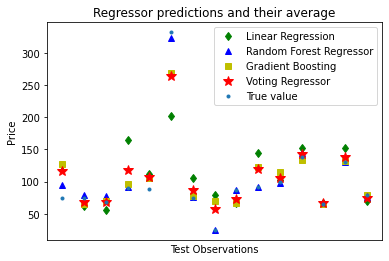

In [89]:
view_n = 15 # number of observations to inspect
plt.figure()
plt.plot(y_pred_1[:view_n], 'gd', label='Linear Regression')
plt.plot(y_pred_2[:view_n], 'b^', label='Random Forest Regressor')
plt.plot(y_pred_3[:view_n], 'ys', label='Gradient Boosting')
plt.plot(y_pred_4[:view_n], 'r*', ms=10, label='Voting Regressor')
plt.plot(y_test.values[:view_n], '.', label="True value")

plt.tick_params(axis='x', which='both', bottom=False, top=False,
                labelbottom=False)
plt.ylabel('Price')
plt.xlabel('Test Observations')
plt.legend(loc="best")
plt.title('Regressor predictions and their average')

plt.show()

In [90]:
print(f"MSE: {mean_squared_error(y_test, y_pred_4)}")
print(f"R^2: {r2_score(y_test, y_pred_4)}")

MSE: 2287.677813936214
R^2: 0.790429304104368


### Step 4: Tune Parameters w/Grid Search

Example with Gradient Boosting Regressor 

See: [Using the prediction pipeline in a grid search](https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html#using-the-prediction-pipeline-in-a-grid-search)

In [91]:
from sklearn.model_selection import GridSearchCV

In [92]:
gradient_boosting = GradientBoostingRegressor(random_state=random_state)
gradient_boosting_pipe = Pipeline([
            ("preprocessor", full_pipeline),
            ("classifier", gradient_boosting)
       ])
gradient_boosting_pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('cat',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['host_response_time', 'host_is_superhost', 'host_has_profile_pic',
       'host_identity_verified', 'neighbourhood_group_cleansed',
       'property_type', 'room_type'...
                                                                  ('standard_scaler',
                                                                   StandardScaler())]),
                                                  Index(['host_listings_count', 'number_of_reviews', 'review_scores_rating',
    

In [93]:
param_grid = {
    #'preprocessor__categorical__imputer__strategy': ['mean', 'median'],
    'classifier__alpha': [1e0, 1e-1, 1e-2, 1e-3],
}

optimized_gradient_boost_model = GridSearchCV(gradient_boosting_pipe, param_grid, cv=10)
optimized_gradient_boost_model

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('categorical',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('cat',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         Index(['host_response_time', 'host_is_superhost', 'host_has_profile_pic',
       'host_identity_verified', 'neighbourhood_group_cleansed...
                                                                         Index(['host_listings_count', 'number_of_reviews', 'review_scores_rating',
       'revi

In [94]:
optimized_gradient_boost_model.fit(X_train_ten_thousand, y_train_ten_thousand)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning:


10 fits failed out of a total of 40.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py", line 525, in fit
    self._check_params()
  File "/usr/local/lib/python3.7/dist-packages/sklearn/

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('categorical',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('cat',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         Index(['host_response_time', 'host_is_superhost', 'host_has_profile_pic',
       'host_identity_verified', 'neighbourhood_group_cleansed...
                                                                         Index(['host_listings_count', 'number_of_reviews', 'review_scores_rating',
       'revi

In [95]:
y_pred = optimized_gradient_boost_model.predict(X_test)

In [96]:
print(f"MSE: {mean_squared_error(y_test, y_pred)}")
print(f"R^2: {r2_score(y_test, y_pred)}")

MSE: 3201.0639506683824
R^2: 0.706755385019134


In [97]:
optimized_gradient_boost_model.best_params_

{'classifier__alpha': 0.1}